In [1]:
from __future__ import division
import numpy as np
import scipy as sc
from itertools import product
import time
import matplotlib.pyplot as plt
import PIL
from numpy import log10
import random, decimal
from random import choice
from math import factorial
from scipy.stats import linregress, gaussian_kde, skew
from scipy import stats
from scipy.spatial import distance
import warnings
import pandas as pd
import re
import os
import math
from collections import Counter
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.outliers_influence import summary_table
import statsmodels.api as sm
from scipy.optimize import linear_sum_assignment

import sys
import itertools


warnings.filterwarnings('ignore')

%config InlineBackend.figure_formats = ['svg']
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

pd.set_option('display.max_columns', None)


In [2]:
def Rlogskew(sad):
    '''
    Calculation of rarity used in:
        A.E. Magurran and B.J. McGill, eds. Biological diversity: frontiers in measurement and assessment. 
        OUP Oxford, 2010.

    '''
    
    S = len(sad)

    if S <= 2.0:
        print('S < 2, cannot compute log-skew')
        sys.exit()

    sad = np.log10(sad)
    mu = np.mean(sad)

    num = 0
    denom = 0
    for ni in sad:
        num += ((ni - mu)**3.0)/S
        denom += ((ni - mu)**2.0)/S

    t1 = num/(denom**(3.0/2.0))
    t2 = (S/(S - 2.0)) * np.sqrt((S - 1.0)/S)

    return t1 * t2


In [3]:


""" Functions for generating random integer partitions of a total q having 
    exactly n parts. """


def conjugate(partition):
    """
    Find the conjugate of an integer partition. Recoded (on 24-Apr-2013) from
    the Sage source code: www.sagenb.org/src/combinat/partition.py """
    
    if partition == []:
        return []
    else:
        l = len(partition)
        conj =  [l] * partition[-1]
        for i in list(range(l - 1, 0, -1)):
            conj.extend([i] * (partition[i - 1] - partition[i]))
        return conj


def NrParts(*args):
    """ Find the number of partition for a given total q and number of parts n. Recoded
        (on 24-Apr-2013) and modified from GAP source code: www.gap-system.org
        
        Modifications for speed based on the proposition that the number of partitions of
        q having n parts is equal to the number of partitions of q-n, if n > q/2 (for odd q)
        or if n >= q/2 (for even q)
        
        Using Sage:
            number_of_partitions(1, 1) = 1 = number_of_partitions(1-1), check
            number_of_partitions(2, 1) = 1 = number_of_partitions(2-1), check
            number_of_partitions(3, 1) = 1 != number_of_partitions(3-1) = 2 , check
            number_of_partitions(4, 2) = 2 = number_of_partitions(4-2), check
            number_of_partitions(5, 2) = 2 != number_of_partitions(5-2) = 3, check
            number_of_partitions(5, 3) = 2 = number_of_partitions(5-3) = 2, check
          
            number_of_partitions(10000, 4999) = 172893842978518096747262197354965370495940268765365154597697652547323374958 
            != number_of_partitions(10000 - 4999) = 172893842978518096747262197354965370495940268765365154597697652547323374960, check
                
            number_of_partitions(10000, 5000)  = 169820168825442121851975101689306431361757683049829233322203824652329144349
            = number_of_partitions(10000-5000) = 169820168825442121851975101689306431361757683049829233322203824652329144349, check
                
            number_of_partitions(10000, 9990) = 42 = number_of_partitions(10000 - 9990), check  """
    
    if len(args) == 2: # Can we use the proposition?
        
        q = args[0]
        n = args[1]
        
        if n >= q/2.0:
            args = [q-n]
    
    numparts = 0  
    if len(args) == 1: # if we're finding p(q)
        
        q = args[0]
        
        numparts = 1                             
        p = [1]*(q+1)
        for i in range(1,q+1):
            numparts = 0
            k = 1
            l = 1                         
            while 0 <= i-(l+k):
                numparts = numparts - (-1)**k * (p[i-l] + p[i-(l+k)])
                k = k + 1
                l = l + 3*k - 2
            
            if 0 <= i-l:
                numparts = numparts - (-1)**k * p[i-l]
            p[i] = numparts
    
    elif len(args) == 2: # if we're finding p(q, n)   
        q = args[0]
        n = args[1]
        
        numparts=0
        if q == n or n == 1:
            numparts = 1
        elif q < n or n == 0:
            numparts = 0
        else:
            q1 = int(q)
            k1 = int(n)
            p = [1]*q1
        
            for i in range(2,k1+1):  
                for m  in range(i+1,q1-i+1+1):
                    p[m] = p[m] + p[m-i]
            
            numparts = p[q1-k1+1]
    
    return numparts

    

def P(D, q, k):
    """ A function to return the number of partitions of q with k or less parts.
    
    Note:
        1. Theorem: The number of partitions of q with k or less parts equals the
           number of partitions of q with k or less as the largest part (see Bona 2006).
           This is a mathematical symmetry, i.e. congruency.
           
           Bona, M. (2006). A Walk Through Combinatorics: An Introduction to Enumeration
             and Graph Theory. 2nd Ed. World Scientific Publishing Co. Singapore.
        
        2. Proposition: The number of partitions of q with k or less parts equals the
           number of partitions of q+k with k as the largest part when k>0, i.e. P(q + k, k).
           No source known, but it can be shown when enumerating the entire feasible set
           or using Sage:
                      
           Checks using Sage:
               number_of_partitions(1+0, 0) = 0 = Partitions(1, max_part=0).cardinality()
               number_of_partitions(1+1, 1) = 1 = Partitions(1, max_part=1).cardinality()
               number_of_partitions(55+3, 3) = 280 = Partitions(55, max_part=3).cardinality()
               number_of_partitions(99+2, 2) = 50 = Partitions(99, max_part=2).cardinality() 
           
    Arguments:
        D : a dictionary for the number of partitions of q having k or less
            parts (or k or less as the largest part), i.e. P(q, q + k).   
        q : the total (i.e. sum across all k or n parts)
        k : the number of parts and also the size of the largest part (congruency)     
    
    Because of the congruency above (Bona 2006) k and n are sometimes used synomously.
    
    """
    
    if (q, k) not in D:
        D[(q, k)] = NrParts(q + k, k)
        # Note from the above: p(q) = p(q + q, q)
        # so NrParts(q) returns the same value as NrParts(q + q, q)
    return [D, D[(q, k)]] # return the updated dictionary and P(q + k, k).


def rand_partitions(q, n, sample_size, method='best', D={}, zeros=False):
    """
    Generate uniform random partitions of Q having N parts.
    
    Arguments:
        Q : Total sum across parts
        N : Number of parts to sum over
        sample_size : number of random partitions to generate
        method : method to use for generating the partition, options include:
            'bottom_up', 'top_down', 'divide_and_conquer', 'multiplicity', and
            'best'. Defaults to 'best'
        D : a dictionary for the number of partitions of Q having N or less
            parts (or N or less as the largest part), i.e. P(Q, Q + N). Defaults
            to a blank dictionary.
        zeros : boolean if True partitions can have zero values, if False
            partitions have only positive values, defaults to False
    
    Returns: A list of lists
    
    Notes:
        method == 'best' attempts to use the values of Q and N to infer what the 
        fastest method to compute the partition.
    
    """
    if q < n and zeros == False:
        zeros = True
    
    parts = []
    if zeros:
    
        """ if zeros are allowed, then we must ask whether Q >= N. If not, then
            the Q is partitioned among a number of parts greater than Q. In which case, 
            some parts must be zero. A random partition for this case would be any 
            random partition of Q with N - Q zeros appended. But, if Q >= N, then a 
            random partition would be any random partition of Q having N or less parts. """
        
        if q >= n:
            # if Q >= N and zero's are allowed, the first part must be equal to or less than N
            Plist = P(D, q, n) 
        elif q < n:
            # if Q < N and zero's are allowed, the first part must be equal to or less than Q
            Plist = P(D, q, q)    
    
    else:
        Plist = P(D, q - n, n) # if zero's are not allowed, the first part must be N.
        
    D = Plist[0]
    numparts = Plist[1]        
    while len(parts) < sample_size:
        rand_int = random.randrange(1, numparts + 1)
        
        if zeros:
            q1 = int(q)
            part = []
        else:
            q1 = int(q - n)
            part = [n]
        
        if method == 'bottom_up':
            part = bottom_up(part, q1, D, rand_int)
        
        if method == 'top_down':
            part = top_down(part, q1, D, rand_int)
        
        if method == 'divide_and_conquer':
            part = divide_and_conquer(part, q1, n, D, rand_int)
        
        if method == 'multiplicity':
            part = multiplicity(part, q1, D, rand_int)
        
        if method == 'best' and zeros == True:
            if q1 < 350 :
                part = bottom_up(part, q1, D, rand_int)
            elif n < 0.4 * q1:
                part = divide_and_conquer(part, q1, n, D, rand_int)
            else:
                part = bottom_up(part, q1, D, rand_int)
                
        elif method == 'best' and zeros == False:
            if n < 0.1 * q1:
                part = multiplicity(part, q1, D, rand_int)
            elif q < 500:
                part = bottom_up(part, q1, D, rand_int)    
            elif q > 500 and n < 0.25*q1:
                part = divide_and_conquer(part, q1, n, D, rand_int)
            else:
                bottom_up(part, q1, D, rand_int)
                
                
        if zeros:
            Zs = [0] * (n - len(part))
            part.extend(Zs)
        parts.append(part)
    return parts


def bottom_up(part, q, D, rand_int):
    """
    Bottom up method of generating uniform random partitions of q having n parts.
    
    Arguments:
        part : a list to hold the partition
        q : the total sum of the partition
        D : a dictionary for the number of partitions of q having n or less
            parts (or n or less as the largest part), i.e. P(q + n, n).        
        rand_int : a number representing a member of the feasible set

    """    
    
    while q > 0:
        for k in range(1, q + 1): # loop through all possible values of the first/largest part
            Plist = P(D, q, k) # number of partitions of q having k or less as the largest part
            D = Plist[0]
            count = Plist[1]
            if count >= rand_int:
                Plist = P(D, q, k - 1)
                D = Plist[0]
                count = Plist[1]
                break
        part.append(k)
        q -= k
        if q == 0:
            break
        rand_int -= count
    part = conjugate(part)    
    return(part)


def top_down(part, q, D, rand_int):
    """
    Top down method of generating uniform random partitions of q having n parts.
    
    Arguments:
        part : a list to hold the partition
        q : the total sum of the partition
        D : a dictionary for the number of partitions of q having n or less
            parts (or n or less as the largest part), i.e. P(q + n, n).        
        rand_int : a number representing a member of the feasible set

    """    
    
    while q > 0:
        if part != []: 
            x = min(part)
        else: 
            x = q
        for k in reversed(range(1, x + 1)): # loop through all possible values of the first/largest part
            Plist = P(D, q, k) # number of partitions of q having k or less as the
            # largest part
            D = Plist[0]
            count = Plist[1]
            if count < rand_int:
                k += 1
                break
        rand_int -= count
        part.append(k)
        q -= k
    part = conjugate(part)
    return(part)


def divide_and_conquer(part, q, n, D, rand_int):
    """
    Divide and conquer method of generating uniform random partitions of q
    having n parts.
        
    Arguments:
        part : a list to hold the partition
        q : the total sum of the partition
        n : number of parts to sum over
        D : a dictionary for the number of partitions of q having n or less
            parts (or n or less as the largest part), i.e. P(q + n, n).        
        rand_int : a number representing a member of the feasible set

    """
    #if n >= 1 and isinstance(n, int): pass 
    #else: print 'n must be a positive integer'
    
    max_int = int(n)
    min_int = int(1)
    while q > 0:
        k = random.randrange(min_int, max_int + 1) # choose a value of the largest part at random
        Plist = P(D, q, k)
        D = Plist[0]
        upper = Plist[1]
        Plist = P(D, q, k - 1)
        D = Plist[0]
        lower = Plist[1]
        if lower < rand_int and rand_int <= upper: 
            part.append(k)
            q -= k
            max_int = k
            min_int = 1
            num = int(upper - lower)
            rand_int = random.randrange(1, num + 1)
        elif rand_int > upper:
            min_int = k + 1    
        elif rand_int <= lower:
            max_int = k - 1    
    part = conjugate(part)
    return part


def get_multiplicity(q, k, D, rand_int, count): 
    """ 
    Find the number of times a value k occurs in a partition that is being
    generated at random by the multiplicity() function. The resulting
    multiplicity is then passed back to the multiplicity() function along with
    an updated value of count and an updated dictionary D
    
    Arguments:
        q : the total sum of the partition
        k : size of the largest (and also first) part 
        D : a dictionary for the number of partitions of q-k*f having k-1 or less
            parts (or k-1 or less as the largest part).                
        rand_int : a number representing a member of the feasible set
        count : number of partitions of q-k*f having k-1 or less parts 
        f : number of times k occur
        multi : list of f values of k """
        
    multi = [] # the multiplicity 
    f = 1
    while f > 0:
        Plist = P(D, (q - k * f), k - 1)
        D = Plist[0]
        count += Plist[1]
        if count >= rand_int:
            count -= Plist[1]
            multi = [k] * f
            break                
        f += 1
    return [D, count, multi]


def multiplicity(part, q, D, rand_int):
    """
    multiplicity method of generating uniform random partitions of q having n
    parts.
    
    Arguments:
        part : a list to hold the partition
        q : the total sum of the partition
        k : size of the largest (and also first) part 
        D : a dictionary for the number of partitions of q having n or less
            parts (or n or less as the largest part), i.e. P(q + n, n).        
        rand_int : a number representing a member of the feasible set

    """
    while q > 0:
        multi = []
        if part != []:
            x = min(part)
        else: 
            x = int(q)
        for k in reversed(range(1, x + 1)): # start with largest k
            Plist = P(D, q, k) # number of partitions of q having k or less as the largest part
            D = Plist[0]
            count = Plist[1]
            if count == rand_int and rand_int == 1:
                multi = [1] * q
                q = 0
                break
            if count < rand_int: # k has been found
                k += 1
                Mlist = get_multiplicity(q, k, D, rand_int, count) # now, find how many times k
                # occurs, i.e. the multiplicity of k, i.e. get_multiplicity()
                D = Mlist[0]
                count = Mlist[1]
                multi = Mlist[2]
                break
        q -= sum(multi)
        part.extend(multi)
        rand_int -= count    
    part = conjugate(part)
    return part
    
    
def test_qnk(q, n=False, k=1):
    """ A function to ensure that q, n, and k are positive integers.
    q : the total sum of the partition
    k : size of the largest (and also first) part
    n : number of parts to sum over 
    
    allows one, two, or three parameters
    by default n=q and k=1 """
    if not n: n = q
    
    '''
    if q >= 0 and isinstance(q, int): pass
    else:
        print q,'q must be a non-negative integer'
        sys.exit()
    if n >=0 and isinstance(n, int): pass
    else:
        print 'n must be a non-negative integer'
        sys.exit()
    if k >= 1 and isinstance(k, int): pass
    else:
        print k,'k must be a non-negative integer'
        sys.exit()
    
    if q < n:
        print q, n, 'q must be >= n'
        sys.exit()
    if q < k and q > 0:
        print 'q must be >= k'
        sys.exit()
    '''
    
    return
        
    
def first_lexical(q, n, k=None):
    """ Find the first lexical partition of q having n parts with k as the largest part
    q : the total sum of the partition
    k : size of the largest (and also first) part 
    n : number of parts in the partition """
    
    test_qnk(q, n)
    partition = []
    if k == None:
        partition.append(q - n + 1)
        ones = [1] * (n - 1)
        partition.extend(ones)
        return partition
    
    elif k < min_max(q, n) or k > max_max(q, n):
        return None
        
    else:
        partition.append(k)
        q -= k
        n -= 1
        while q > 0:
            k = min(k, q - n + 1)
            partition.append(k)
            q -= k
            n -= 1
        
    return partition


def next_restricted_part(partition):
    """ Find the next lexical partition of q having n parts
    q : the total sum of the partition
    n : number of parts in the partition
    halves : two halves of the partition """
    
    q = sum(partition)
    n = len(partition)
    test_qnk(q, n)
    
    if partition == last_lexical(q, n):
        return first_lexical(q, n, None)

    for i in enumerate(reversed(partition)):
        if i[1] - partition[-1] > 1:
            if i[0] == (n - 1):
                partition = first_lexical(q, n, int(i[1] - 1))
                return partition
            else:
                halves = np.split(partition, [n - i[0] - 1])
                h1 = list(halves[0])
                h2 = list(halves[1])
                next = list(first_lexical(int(sum(h2)), int(len(h2)), int(h2[0]) - 1))
                return h1 + next




def get_central_tendency_mean_var(parts):
    """ Find the integer partition in a random sample with the greatest average commonness 
        to all other partitions in the sample. This partition is taken to represent the 
        central tendency of the set. """
    
    if len(parts) == 1:
        return parts[0]
    
    xpart = []
    a1 = 0 
    v1 = 0 
    for part in parts:
        in_common = []
        ct1 = 0
        for a in part: # for each rank
            c = 0
            for sad in parts: 
                if a == sad[ct1]:
                    c += 1
            
            in_common.append(c)
            ct1 += 1
            
        a2 = np.mean(in_common)
        v2 = np.var(in_common)  
        if a2 > a1:
            a1 = a2
            v1 = v2
            xpart = part
        elif a2 == a1:
            if v2 < v1:
                a1 = a2
                v1 = v2
                xpart = part
                
    return xpart


def last_lexical(q, n):
    """ Find the last lexical (i.e. most even) partition of q having n parts
    q : the total sum of the partition
    n : number of parts in the partition
    j : place holder """
    
    test_qnk(q, n)
    partition = [int(math.floor(float(q) / float(n)))] * n # a list of n integer 
    # all with the same value, but not necessarily summing to q
    _remainder = int(q % n)
    j = 0
    while _remainder > 0: # distribute the remainder evenly among parts
    # of the partition
        partition[j] += 1
        _remainder -= 1
        j += 1
    return partition


def min_max(q, n):
    """ Find the smallest possible maximum value for the first part in a partition
    of q having n parts """
    test_qnk(q, n)
    min_int, r = divmod(q, n)
    return min_int + 1 if r else min_int



def max_max(q, n):
    """ Find the largest possible maximum value for the first part in a partition
    of q having n parts """
    
    test_qnk(q, n)
    
    maxk = q - n + 1
    return maxk


#       

# GENERATE PREDICTED FROM N-S FEASIBLE SETS

In [243]:
#backup_RADs = list(RADs)
RADs = list(backup_RADs)

In [238]:
i = 0
RADs = []
Ns = np.logspace(0, 4, 100).tolist()
for i, ni in enumerate(Ns):
    
    i += 1
    
    if i % 25 == 0:
        print("i:", i)
        
    e = np.random.uniform(np.log10(8), 4)
    N = int(round(10**e))

    e = np.random.uniform(0.45, 0.4)
    m = 1.75#np.random.uniform(1.72, 1.78)
    S = int(round(m*N**e))
    
    partition = rand_partitions(N, S, sample_size=1, method='best', D={})
    RADs.append(partition[0])


i: 25
i: 50
i: 75
i: 100


In [244]:

N_ls = []
S_ls = []
NS_ls = []
skew_ls = []
log_mod_skew_ls = []
log_mod_skew_log_ls = []
shift_ls = []
shift_log_ls = []
perc_1_ls = []
perc_01_ls = []


for RAD in RADs:
    
    if np.max(RAD) <= 1:
        continue
        
    N = int(sum(RAD))
    S = len(RAD)
    
    # 1. skewness of abundances
    skewness = skew(RAD)
            
    # 2. log-modulo transformation of skewnness
    lms = np.log10(np.abs(float(skewness)) + 1)
    if skewness < 0: 
        lms = lms * -1
    log_mod_skew = float(lms)
            
            
    # 4. Shift (S) on abundances
    min_ = 1#np.nanmin(RAD)
    max_ = np.nanmax(RAD)
    C = np.mean(RAD)
    shift = (max_ - C)/(max_ - min_)
            
            
    # 5. Shift (S) on log-abundances
    logRAD = np.log10(RAD)
    min_ = 0#np.nanmin(logRAD)
    max_ = np.nanmax(logRAD)
    C = np.mean(logRAD)
    shift_log = (max_ - C)/(max_ - min_)
        
    #6. Percent 1's and 2's
    perc_1 = RAD.count(1)/S
            
    #7. Percent with n/N < 0.01
    num_01 = 0
    for r in RAD:
        if r/N < 0.01:
            num_01 += 1
                    
    perc_01 = num_01/S
            
    #8. N/S
    NS = N/S
            
            
    N_ls.append(int(N))
    S_ls.append(int(S))
    skew_ls.append(skewness)
    #logskew_ls.append(logskew)
    log_mod_skew_ls.append(log_mod_skew)
    shift_ls.append(shift)
    shift_log_ls.append(shift_log)
    perc_1_ls.append(perc_1)
    perc_01_ls.append(perc_01)
    NS_ls.append(NS)


tdf = pd.DataFrame({
    'N': N_ls,
    'S': S_ls,
    'skew': skew_ls,
    'log_mod_skew': log_mod_skew_ls,
    'Shift': shift_ls,
    'Shift_log': shift_log_ls,
    'Percent_1s': perc_1_ls,
    'Percent_01s': perc_01_ls,
    'N/S': NS_ls,
})

print(tdf.shape)
tdf.head()

(1000, 9)


N   S      skew  log_mod_skew     Shift  Shift_log  Percent_1s  \
0   363   9  0.821822      0.260506  0.598639   0.260658    0.000000   
1   349  13  1.344422      0.370036  0.741538   0.469948    0.230769   
2   904  11  0.039485      0.016818  0.516775   0.215510    0.000000   
3  5829  28  2.931302      0.594536  0.852647   0.372259    0.035714   
4  1130  25  0.769520      0.247856  0.640650   0.266054    0.000000   

   Percent_01s         N/S  
0     0.000000   40.333333  
1     0.230769   26.846154  
2     0.000000   82.181818  
3     0.428571  208.178571  
4     0.160000   45.200000

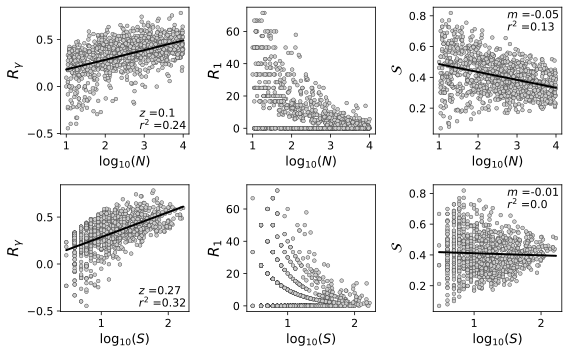

In [246]:
tdf2 = tdf.copy(deep=True)
tdf2 = tdf2[np.isfinite(tdf2['log_mod_skew'])]


X1 = np.log10(tdf2['N'])
x1_lab = 'log' + r'$_{10}(N)$'

X2 = np.log10(tdf2['S'])
x2_lab = 'log' + r'$_{10}(S)$'

y1 = tdf2['log_mod_skew']
y1_lab = r'$R_{\gamma}$'

y2 = 100 * tdf2['Percent_1s']
y2_lab = r'$R_{1}$'

y3 = tdf2['Shift_log']
y3_lab = r"$\mathcal{S}$"


fs = 15

# Plotting
fig = plt.figure(figsize=(9, 5.5))  # Adjusted width for 3 columns

# Define X and Y pairs
X_vars = [X1, X2]
x_labels = [x1_lab, x2_lab]
Y_vars = [y1, y2, y3]
y_labels = [y1_lab, y2_lab, y3_lab]

# Loop through and create subplots in a 2-row, 3-column layout
for i, X in enumerate(X_vars):
    for j, Y in enumerate(Y_vars):
        ax = plt.subplot(2, 3, i * 3 + j + 1)  # 2 rows, 3 columns

        # Scatter plot
        if y_labels[j] == y2_lab:   
            plt.scatter(X, Y, facecolors='0.8', s=14, edgecolors='0.2', linewidths=0.4)
        
        else:
            # Linear regression
            slope, intercept, r_val, p_val, se_ = linregress(x=X, y=Y)
            fitted_vals = slope * np.array(X) + intercept
            #print('slope:', slope)
            
            if y_labels[j] == y1_lab:
                plt.scatter(X, Y, facecolors='0.8', s=14, edgecolors='0.2', 
                            linewidths=0.4,
                            label = r'$z$ =' + str(round(slope, 2)) + '\n' + r'$r^{2}$ =' +str(round(r_val**2, 2)), 
                           )
            else:
                plt.scatter(X, Y, facecolors='0.8', s=14, edgecolors='0.2', 
                            linewidths=0.4,
                            label = r'$m$ =' + str(round(slope, 2)) + '\n' + r'$r^{2}$ =' +str(round(r_val**2, 2)), 
                           )
                
            #equation = r"$R_{\gamma}$" + ' = ' + f"{round(slope, 2)}" + r'$\cdot$' + 'log' + r'$_{10}(N)$ + ' + f"{round(intercept, 2)}"
            
            #r_squared = "\n" + f"$r^2$ = {round(r_val**2, 2)}"
            #r_squared = "\n" + f"$p$ = {round(p_val, 3)}"

            # Plot regression line
            plt.plot(X, fitted_vals, color='k', linewidth=2)

            # Place equation and r² above the plot
            #ax.text(0.5, 1.05, f"{equation}, {r_squared}",
            #        transform=ax.transAxes,
            #        ha='center', va='bottom',
            #        fontsize=fs-4)

        plt.xlabel(x_labels[i], fontsize=fs-2)
        plt.ylabel(y_labels[j], fontsize=fs)
        plt.tick_params(axis='both', labelsize=fs-4)
        legend = plt.legend(
            fontsize=fs-4,
            frameon=True,
            facecolor='white',
            edgecolor='none',
            framealpha=0.3,
            markerscale=0,
            borderpad=0.05,         # Space inside the box
            labelspacing=0.,      # Space between entries
            handlelength=0,        # Length of the marker symbol
            handletextpad=0.,     # Space between marker and text
            borderaxespad=0.2      # Space between legend and plot axes
        )
        
        if np.max(X) > 3:
            plt.xticks(ticks=[1, 2, 3, 4], labels=[1, 2, 3, 4])
        else:
            plt.xticks(ticks=[1, 2], labels=[1, 2])
    
# Final figure adjustments
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.45, hspace=0.4)  # Adjusted spacing

plt.savefig('Final_Figs/manuscript/Fig4_Rarity.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig4_Rarity.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.show()

In [149]:
d_N = []
d_S = []
d_NS = []

d_Shift = []
d_R = []
d_P12 = []

N_ls = np.log10(tdf2['N']).tolist()
S_ls = np.log10(tdf2['S']).tolist()

Shift_ls = tdf2['Shift_log'].tolist()
R_ls = tdf2['log_mod_skew'].tolist()
P12_ls = tdf['Percent_1s'].tolist()

s = tdf2.shape[0]
for j in range(5000):
    
    i1 = np.random.randint(s)
    i2 = np.random.randint(s)
    
    d_N.append(N_ls[i1] - N_ls[i2])
    d_S.append(S_ls[i1] - S_ls[i2])
    
    d_Shift.append(Shift_ls[i1] - Shift_ls[i2])
    d_R.append(R_ls[i1] - R_ls[i2])
    d_P12.append(100*P12_ls[i1] - 100*P12_ls[i2])
    


In [150]:

X1 = list(d_N)
x1_lab = 'Δ[log' + r'$_{10}(N)$]'

X2 = list(d_S)
x2_lab = 'Δ[log' + r'$_{10}(S)$]'

y1 = list(d_R)
y1_lab = 'Δ' + r'$R_{\gamma}$'

y2 = list(d_P12)
y2_lab = 'Δ' + r'$R_{1}$'

y3 = list(d_Shift)
y3_lab = 'Δ' + r"$\mathcal{S}$"



fs = 15

# Plotting
fig = plt.figure(figsize=(9, 6))  # Adjusted width for 3 columns

# Define X and Y pairs
X_vars = [X1, X2]
x_labels = [x1_lab, x2_lab]
Y_vars = [y1, y2, y3]
y_labels = [y1_lab, y2_lab, y3_lab]

# Loop through and create subplots in a 2-row, 3-column layout
for i, X in enumerate(X_vars):
    for j, Y in enumerate(Y_vars):
        ax = plt.subplot(2, 3, i * 3 + j + 1)  # 2 rows, 3 columns

        #X = np.abs(X)
        
        # Scatter plot
        if y_labels[j] == y3_lab:   
            plt.scatter(X, Y, facecolors='0.8', s=14, edgecolors='0.2', linewidths=0.4)
        else:
            plt.scatter(X, Y, facecolors='0.8', s=14, edgecolors='0.2', linewidths=0.4)

        if 1 == 1: #y_labels[j] == y1_lab and x_labels[i] == x1_lab:
            # Linear regression
            slope, intercept, r_val, _, _ = linregress(X, Y)
            fitted_vals = slope * np.array(X) + intercept
            
            if intercept >= 0: 
                equation = f"$y = {round(slope, 2)}x + {round(intercept, 2)}$"
            elif intercept < 0: 
                equation = f"$y = {round(slope, 2)}x {round(intercept, 2)}$"

            
            r_squared = f"$r^2$ = {round(r_val**2, 2)}"

            # Plot regression line
            plt.plot(X, fitted_vals, color='k', linewidth=2)

            # Place equation and r² above the plot
            ax.text(0.5, 1.05, f"{equation}, {r_squared}",
                    transform=ax.transAxes,
                    ha='center', va='bottom',
                    fontsize=fs-6)

        plt.xlabel(x_labels[i], fontsize=fs-2)
        plt.ylabel(y_labels[j], fontsize=fs)
        plt.tick_params(axis='both', labelsize=fs-4)

# Final figure adjustments
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.48, hspace=0.6)  # Adjusted spacing
plt.savefig('Final_Figs/manuscript/Fig5_Rarity.jpg', bbox_inches='tight', format='jpg', dpi=600)
plt.savefig('Final_Figs/manuscript/Fig5_Rarity.pdf', bbox_inches='tight', format='pdf', dpi=600)
plt.show()
